In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [2]:
import efficientnet.tfkeras as efn

In [3]:
# Definir la ruta del dataset
DATASET_PATH = r"..\\datos" 
train_dir = os.path.join(DATASET_PATH, 'Train\Train')
test_dir = os.path.join(DATASET_PATH, 'Test\Test')

<>:3: SyntaxWarning: invalid escape sequence '\T'
<>:4: SyntaxWarning: invalid escape sequence '\T'
<>:3: SyntaxWarning: invalid escape sequence '\T'
<>:4: SyntaxWarning: invalid escape sequence '\T'
C:\Users\cmairal\AppData\Local\Temp\ipykernel_31384\817812489.py:3: SyntaxWarning: invalid escape sequence '\T'
  train_dir = os.path.join(DATASET_PATH, 'Train\Train')
C:\Users\cmairal\AppData\Local\Temp\ipykernel_31384\817812489.py:4: SyntaxWarning: invalid escape sequence '\T'
  test_dir = os.path.join(DATASET_PATH, 'Test\Test')


In [4]:
# Número de clases (11 especies de árboles)
NUM_CLASSES = 11
IMG_SIZE = 256  # Tamaño de entrada de EfficientNet
BATCH_SIZE = 8
BUFFER_SIZE = 100
EPOCHS = 10
AUTOTUNE = tf.data.AUTOTUNE

In [5]:
# Cargar dataset y organizarlo en TensorFlow
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=123,
    label_mode='categorical'  # etiquetas serán one-hot
)


Found 4385 files belonging to 11 classes.


In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomContrast(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.1, 0.1),
])

#train_data = train_data.map(lambda x, y: (data_augmentation(x, training=True), y))


In [6]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=123,
    label_mode='categorical'  # etiquetas serán one-hot
)

Found 1958 files belonging to 11 classes.


In [7]:
# Definir modelo con EfficientNetB0
base_model = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = True  # Descongelar todas las capas

# Opcional: Congelar las primeras capas y entrenar solo las últimas
# Congelar solo las primeras capas
#for layer in base_model.layers[:100]:  
    #layer.trainable = False

In [8]:
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    #layers.Dropout(0.5),  # Ya incluido, pero se puede aumentar a 0.6
    #layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

In [9]:
# Compilar el modelo
opt = optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

In [10]:
# Entrenamiento del modelo
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=7,
    #callbacks=[early_stopping]
)

Epoch 1/10


549/549 ━━━━━━━━━━━━━━━━━━━━ 645s 1s/step - categorical_accuracy: 0.3093 - loss: 2.0449 - val_categorical_accuracy: 0.5255 - val_loss: 1.4078
Epoch 2/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 560s 1s/step - categorical_accuracy: 0.7109 - loss: 0.9554 - val_categorical_accuracy: 0.6369 - val_loss: 1.1511
Epoch 3/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 559s 1s/step - categorical_accuracy: 0.8452 - loss: 0.5323 - val_categorical_accuracy: 0.6558 - val_loss: 1.1048
Epoch 4/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 576s 1s/step - categorical_accuracy: 0.9028 - loss: 0.3237 - val_categorical_accuracy: 0.6798 - val_loss: 1.0972
Epoch 5/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 562s 1s/step - categorical_accuracy: 0.9475 - loss: 0.1924 - val_categorical_accuracy: 0.6890 - val_loss: 1.2903
Epoch 6/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 552s 1s/step - categorical_accuracy: 0.9556 - loss: 0.1539 - val_categorical_accuracy: 0.6987 - val_loss: 1.2592
Epoch 7/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 561s 1s/step - categorical_accuracy: 0.9679 - loss: 0

In [11]:
# Evaluación final
test_loss, test_acc = model.evaluate(test_data)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

245/245 ━━━━━━━━━━━━━━━━━━━━ 47s 193ms/step - categorical_accuracy: 0.6821 - loss: 1.5145
Test Accuracy: 70.02%


In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Obtener etiquetas verdaderas y convertirlas a enteros
y_true = np.concatenate([y.numpy() for _, y in test_data], axis=0)
y_true = np.argmax(y_true, axis=1)  # Convertir de one-hot a enteros

# Obtener predicciones
y_pred = np.argmax(model.predict(test_data), axis=1)

# Crear matriz de confusión
cm = confusion_matrix(y_true, y_pred)



245/245 ━━━━━━━━━━━━━━━━━━━━ 76s 309ms/step


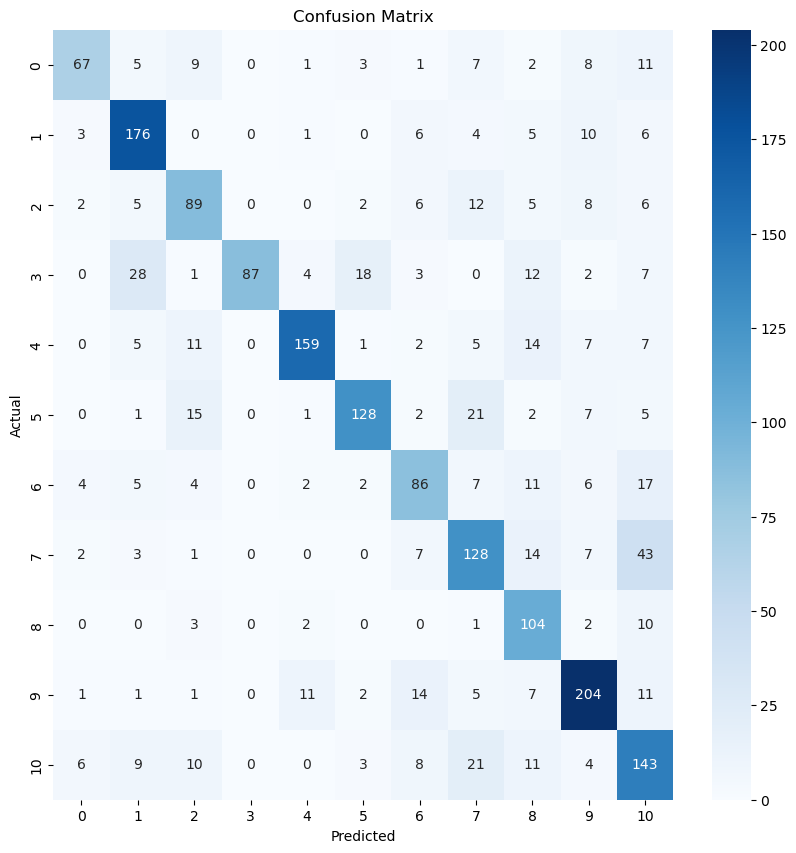

In [13]:
# Graficar la matriz de confusión
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()